In [1]:
import os
from tqdm import tqdm
import cv2
import numpy as np
import random
from time import time



DATADIR='C:/Users/madhu_g/Desktop/Madhu Jogee/Galbladdor/Galblader'

CATEGORIES = ["1Gallstones", "2Abdomen and retroperitoneum", "3cholecystitis", "4Membranous and gangrenous cholecystitis", "5Perforation", "6Polyps and cholesterol crystals", "7Adenomyomatosis", "8Carcinoma", "9Various causes of gallbladder wall thickening"]

IMG_SIZE = 128

num_epoch =100

batch_size=64


os.chdir(DATADIR)

DATA = []

In [2]:

for category in CATEGORIES:
    path=os.path.join(DATADIR,category)
    class_num = CATEGORIES.index(category)

    for img in tqdm(os.listdir(path)):

        try:
            img_array = cv2.imread(os.path.join(path,img))
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            DATA.append([img_array, class_num])

        except Exception as e:
            pass

random.shuffle(DATA)

100%|███████████████████████████████████████████████████████████████████████████████| 990/990 [00:08<00:00, 111.31it/s]


In [3]:
from tensorflow.keras.utils import to_categorical
X = []

y = []

for features,label in DATA:
    X.append(features)
    y.append(label)

print(len(X))

print(len(X[0]))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

y = np.array(to_categorical(y))



10692
128


In [4]:
print(X.shape,y.shape)
print(y[:10])

(10692, 128, 128, 3) (10692, 9)
[[0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [5]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=50,stratify=y)



print("Training Samples",x_train.shape,y_train.shape)
print("Testing Samples",x_test.shape,y_test.shape)



Training Samples (9622, 128, 128, 3) (9622, 9)
Testing Samples (1070, 128, 128, 3) (1070, 9)


In [6]:
del DATA
del X
del y

In [7]:
def loss_fn(y_true, y_pred):
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.45 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    return tf.reduce_mean(tf.reduce_sum(L, axis=1))

In [8]:
#DEFINING New SQUASH function
import keras.backend as K

def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors



# def squash(s, axis=-1):
#     # Compute the squared norm using TensorFlow (sum of squares of the elements)
#     squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keepdims=True)
#     # Use TensorFlow to compute the norm (instead of np.linalg.norm)
#     norm_s = tf.sqrt(squared_norm)
#     # Calculate the squash factor
#     squash_factor = norm_s / (1. + squared_norm)
#     # The unit vector is 's'. Make sure to keep the dimensions for broadcasting.
#     unit_vector = s
#     # Return the squashed output, ensuring squash_factor's shape is broadcastable.
#     return squash_factor * unit_vector

In [9]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, Reshape, Dense, Multiply, Lambda, Flatten,BatchNormalization,PReLU,Dropout,Activation
from keras import regularizers
from keras.regularizers import l2

input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

cnn1 = Conv2D(32, (3,3), 2, padding='same', activation='relu',name="cnn1")(input_layer)
b_cnn1=BatchNormalization()(cnn1)

cnn2 = Conv2D(16, (3,3), 2, padding='same', activation='relu',name="cnn2")(b_cnn1)
b_cnn2=BatchNormalization()(cnn2)

cnn3 = Conv2D(64, (3,3), 2, padding='same', activation='relu',name="cnn3")(b_cnn2)
b_cnn3=BatchNormalization()(cnn3)

cnn4 = Conv2D(32, (3,3), 2, padding='same', activation='relu',name="cnn4")(b_cnn3)
b_cnn4=BatchNormalization()(cnn4)

cnn5 = Conv2D(64, (3,3), 2, padding='same', activation='relu',name="cnn5")(b_cnn4)
b_cnn5=BatchNormalization()(cnn5)


#change this for cnn layers
b_cnn7 = Lambda(squash, output_shape=lambda s: s)(b_cnn5)


primary_caps = Reshape((-1, 8))(b_cnn7)



primary_caps=Dropout(0.25)(primary_caps)
primary_caps = Dense(64,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='swish')(primary_caps)
primary_caps=PReLU()(primary_caps)


routing_weights1 = Dense(64,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='gelu')(primary_caps)
weighted_caps1 = Multiply()([primary_caps, routing_weights1])
weighted_caps1=PReLU()(weighted_caps1)
weighted_caps1=Dropout(0.25)(weighted_caps1)


routing_weights2 = Dense(64,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='gelu')(weighted_caps1)
weighted_caps2 = Multiply()([primary_caps, routing_weights2])
weighted_caps2=PReLU()(weighted_caps2)
weighted_caps2=Dropout(0.25)(weighted_caps2)


routing_weights3 = Dense(64,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='gelu')(weighted_caps2)
weighted_caps3 = Multiply()([primary_caps, routing_weights3])
weighted_caps3=PReLU()(weighted_caps3)
weighted_caps3=Dropout(0.25)(weighted_caps3)


routing_weights4 = Dense(64,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='gelu')(weighted_caps3)
weighted_caps4 = Multiply()([primary_caps, routing_weights4])
weighted_caps4=PReLU()(weighted_caps4)
weighted_caps4=Dropout(0.25)(weighted_caps4)


routing_weights5 = Dense(64,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='gelu')(weighted_caps4)
weighted_caps5 = Multiply()([primary_caps, routing_weights5])
weighted_caps5=PReLU()(weighted_caps5)
weighted_caps5=Dropout(0.25)(weighted_caps5)

#change this for routing
flattened = Flatten()(weighted_caps2)


dense1 = Dense(64,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='gelu')(flattened)
# dense1 = Dropout(0.7)(dense1)
dense2 = Dense(256,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='gelu')(dense1)
# dense2 = Dropout(0.75)(dense2)

output_layer = Dense(len(CATEGORIES),kernel_initializer='lecun_normal', bias_initializer='zeros', activation='softmax')(dense2)

model2 = Model(inputs=input_layer, outputs=output_layer)

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 cnn1 (Conv2D)                  (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['cnn1[0][0]']                   
 alization)                                                                                       
                                                                                              

In [10]:
from keras.optimizers import Nadam,Adam

model2.compile(optimizer=Adam(learning_rate=1e-03),loss=loss_fn,metrics=['acc'])

In [11]:
from keras.backend import clear_session
clear_session()

In [12]:
start_time = time()
history2=model2.fit(x_train,y_train,epochs=num_epoch,batch_size=batch_size,verbose=1,validation_data=(x_test,y_test))
training_time = time() - start_time

Epoch 1/100
151/151 [==============================] - 6s 21ms/step - loss: 0.6101 - acc: 0.1655 - val_loss: 0.6177 - val_acc: 0.1794
Epoch 2/100
151/151 [==============================] - 3s 18ms/step - loss: 0.5158 - acc: 0.3279 - val_loss: 0.5407 - val_acc: 0.3037
Epoch 3/100
151/151 [==============================] - 3s 18ms/step - loss: 0.4008 - acc: 0.4979 - val_loss: 0.3843 - val_acc: 0.5271
Epoch 4/100
151/151 [==============================] - 3s 18ms/step - loss: 0.3118 - acc: 0.6203 - val_loss: 0.2873 - val_acc: 0.6598
Epoch 5/100
151/151 [==============================] - 3s 18ms/step - loss: 0.2464 - acc: 0.7042 - val_loss: 0.2270 - val_acc: 0.7280
Epoch 6/100
151/151 [==============================] - 3s 18ms/step - loss: 0.1904 - acc: 0.7723 - val_loss: 0.1761 - val_acc: 0.8028
Epoch 7/100
151/151 [==============================] - 3s 18ms/step - loss: 0.1547 - acc: 0.8157 - val_loss: 0.2289 - val_acc: 0.7243
Epoch 8/100
151/151 [==============================] - 3s 19ms

In [13]:
start_time = time()
test_loss,test_acc = model2.evaluate(x_test,  y_test, verbose=2)
print('Test Loss: %.3f, Test Accuracy: %.3f' % (test_loss, test_acc))
testing_time = time()-start_time

34/34 - 0s - loss: 0.0017 - acc: 0.9991 - 289ms/epoch - 9ms/step
Test Loss: 0.002, Test Accuracy: 0.999


In [14]:
model2.save('C:/Users/madhu_g/Desktop/Madhu Jogee/Galbladdor/Files/Generalization R2/GBCapsNetR2.h5')

In [15]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

print("TensorFlow version:", tf.__version__)
print("tf.keras version:", tf.keras.__version__)


TensorFlow version: 2.10.1
Keras version: 2.10.0
TensorFlow version: 2.10.1
tf.keras version: 2.10.0


In [16]:
print("Training Time ",training_time)
print("Testing TIme ",testing_time)

Training Time  282.57609009742737
Testing TIme  0.34102916717529297


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


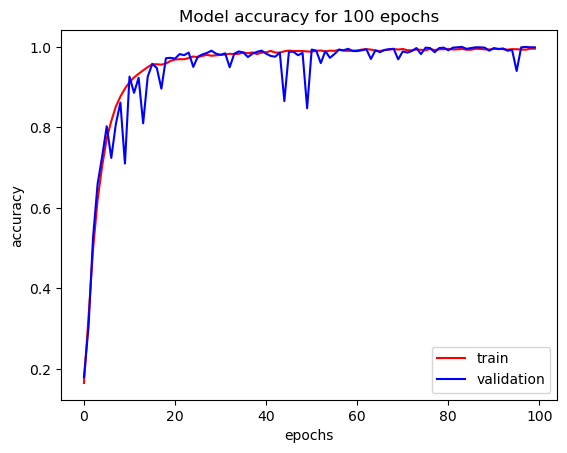

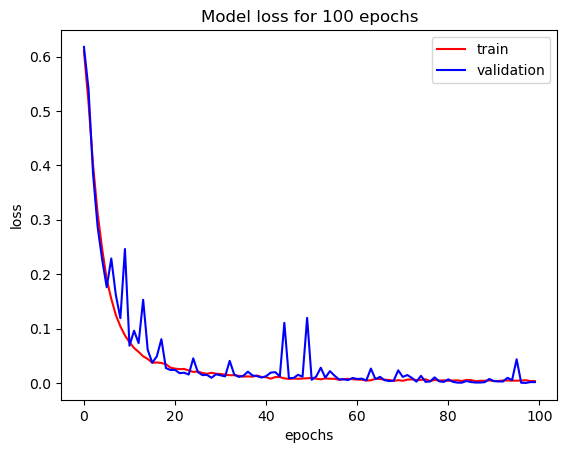

In [17]:
print(history2.history.keys())

import matplotlib.pyplot as plt


plt.plot(history2.history['acc'],color='r')
plt.plot(history2.history['val_acc'],color='b')
plt.title('Model accuracy for {0} epochs'.format(num_epoch))
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='best')
plt.show()



plt.plot(history2.history['loss'],color='r')
plt.plot(history2.history['val_loss'],color='b')
plt.title('Model loss for {0} epochs'.format(num_epoch))
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='best')
plt.show()

34/34 [==============================] - 0s 6ms/step
AUC Train Class 0: 1.0
AUC Test Class 0: 1.0
AUC Train Class 1: 1.0
AUC Test Class 1: 1.0
AUC Train Class 2: 0.999999887099045
AUC Test Class 2: 0.999963578420214
AUC Train Class 3: 0.9999997868172249
AUC Test Class 3: 0.9999656596354771
AUC Train Class 4: 1.0
AUC Test Class 4: 1.0
AUC Train Class 5: 1.0
AUC Test Class 5: 0.9999999999999999
AUC Train Class 6: 1.0
AUC Test Class 6: 1.0
AUC Train Class 7: 1.0
AUC Test Class 7: 1.0
AUC Train Class 8: 1.0
AUC Test Class 8: 1.0


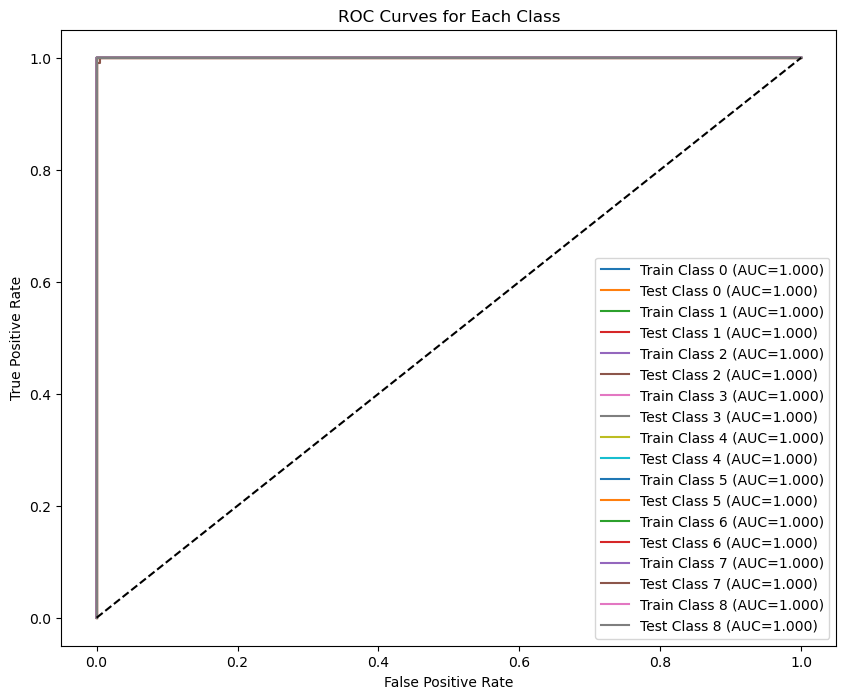

In [18]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Assuming you have 9 classes, label binarize the output
n_classes = 9
y_train_binary = label_binarize(y_train, classes=np.arange(n_classes))
y_test_binary = label_binarize(y_test, classes=np.arange(n_classes))

# Calculate predicted probabilities for each class
y_train_pred_proba = model2.predict(x_train)
y_test_pred_proba = model2.predict(x_test)

# Initialize lists to hold fpr, tpr, and auc for each class
fpr_train_all, tpr_train_all, auc_train_all = [], [], []
fpr_val_all, tpr_val_all, auc_val_all = [], [], []

# Iterate over each class to compute ROC and AUC
for i in range(n_classes):
    fpr_train, tpr_train, _ = roc_curve(y_train_binary[:, i], y_train_pred_proba[:, i])
    auc_train = roc_auc_score(y_train_binary[:, i], y_train_pred_proba[:, i])

    fpr_val, tpr_val, _ = roc_curve(y_test_binary[:, i], y_test_pred_proba[:, i])
    auc_val = roc_auc_score(y_test_binary[:, i], y_test_pred_proba[:, i])

    fpr_train_all.append(fpr_train)
    tpr_train_all.append(tpr_train)
    auc_train_all.append(auc_train)

    fpr_val_all.append(fpr_val)
    tpr_val_all.append(tpr_val)
    auc_val_all.append(auc_val)

    print(f"AUC Train Class {i}: {auc_train}")
    print(f"AUC Test Class {i}: {auc_val}")

# Plotting the ROC curves for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr_train_all[i], tpr_train_all[i], label=f'Train Class {i} (AUC={auc_train_all[i]:.3f})')
    plt.plot(fpr_val_all[i], tpr_val_all[i], label=f'Test Class {i} (AUC={auc_val_all[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.show()


34/34 [==============================] - 0s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       133
           1       1.00      1.00      1.00       117
           2       1.00      0.99      1.00       115
           3       0.99      1.00      1.00       123
           4       1.00      1.00      1.00       106
           5       1.00      1.00      1.00       102
           6       1.00      1.00      1.00       116
           7       1.00      1.00      1.00       159
           8       1.00      1.00      1.00        99

    accuracy                           1.00      1070
   macro avg       1.00      1.00      1.00      1070
weighted avg       1.00      1.00      1.00      1070



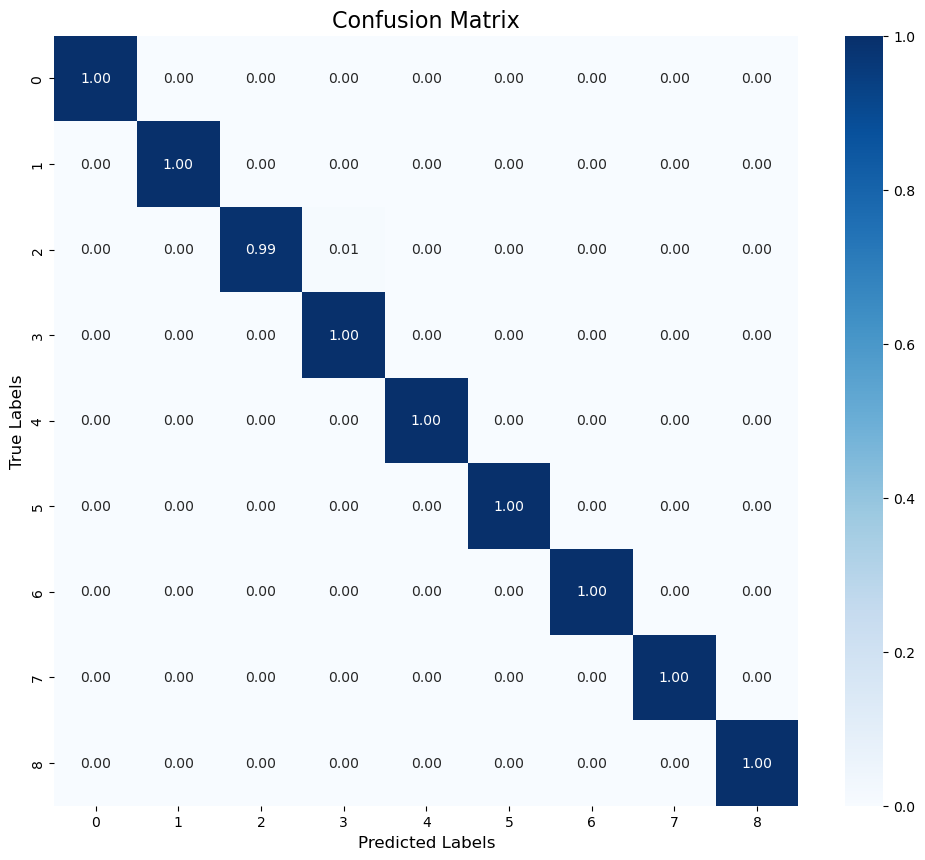

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict probabilities for the test set
y_test_pred_proba = model2.predict(x_test)

# Convert predictions to class labels
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Ensure y_test is in the right format (1D array for binary or single-label multiclass)
if y_test.shape[1] > 1:
    y_test_binary = np.argmax(y_test, axis=1)  # Convert multilabel to single-label
else:
    y_test_binary = y_test.flatten()  # Make sure it's 1D

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_test_pred)

# Normalize confusion matrix if needed
conf_matrix_values = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Print classification report
c_r = classification_report(y_test_binary, y_test_pred, target_names=[str(i) for i in range(9)])
print("Classification Report:")
print(c_r)

# Increase figure size for better clarity
plt.figure(figsize=(12, 10))  # Adjust the figure size (width, height)

# Plot confusion matrix using Seaborn heatmap
sns.heatmap(conf_matrix_values, annot=True, fmt=".2f", cmap="Blues", xticklabels=[str(i) for i in range(9)],
            yticklabels=[str(i) for i in range(9)], cbar=True)

# Titles and labels
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Display the plot
plt.show()


34/34 [==============================] - 0s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       133
           1       1.00      1.00      1.00       117
           2       1.00      0.99      1.00       115
           3       0.99      1.00      1.00       123
           4       1.00      1.00      1.00       106
           5       1.00      1.00      1.00       102
           6       1.00      1.00      1.00       116
           7       1.00      1.00      1.00       159
           8       1.00      1.00      1.00        99

    accuracy                           1.00      1070
   macro avg       1.00      1.00      1.00      1070
weighted avg       1.00      1.00      1.00      1070



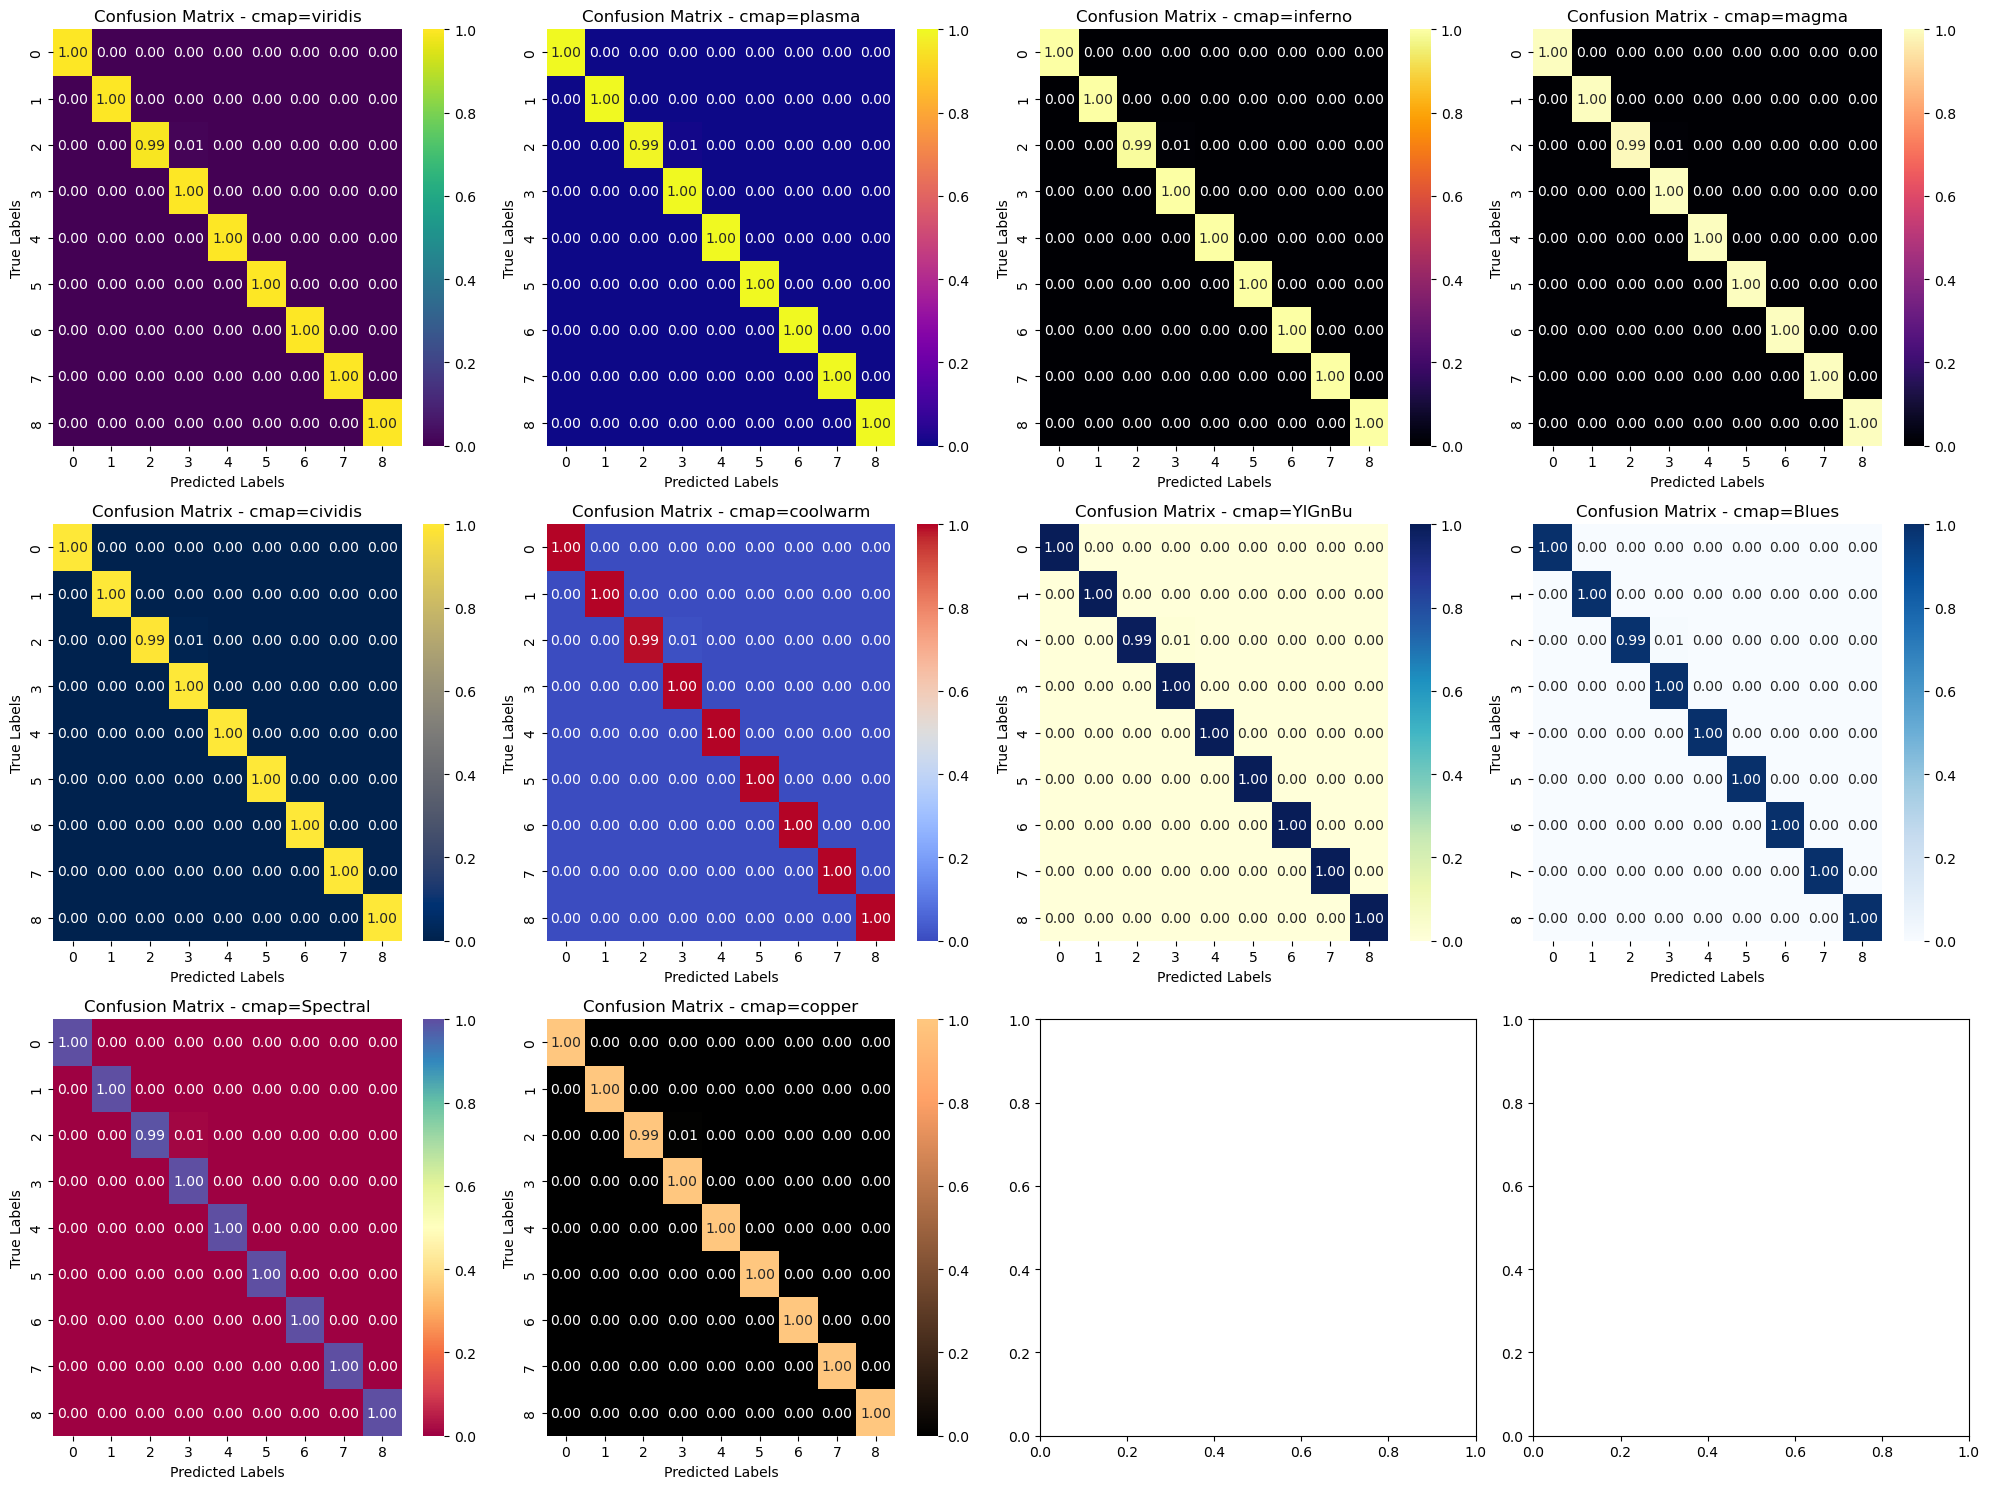

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Predict probabilities for the test set
y_test_pred_proba = model2.predict(x_test)

# Convert predictions to class labels
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Ensure y_test is in the right format (1D array for binary or single-label multiclass)
if y_test.shape[1] > 1:
    y_test_binary = np.argmax(y_test, axis=1)  # Convert multilabel to single-label
else:
    y_test_binary = y_test.flatten()  # Make sure it's 1D

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_test_pred)

# Normalize confusion matrix if needed
conf_matrix_values = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Print classification report
c_r = classification_report(y_test_binary, y_test_pred, target_names=[str(i) for i in range(9)])
print("Classification Report:")
print(c_r)

# List of popular colormaps
cmap_list = [
    "viridis", "plasma", "inferno", "magma", "cividis",
    "coolwarm", "YlGnBu", "Blues", "Spectral", "copper"
]

# Set up the figure size for multiple subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot confusion matrix for each color map
for idx, cmap in enumerate(cmap_list):
    sns.heatmap(conf_matrix_values, annot=True, fmt=".2f", cmap=cmap,
                xticklabels=[str(i) for i in range(9)], yticklabels=[str(i) for i in range(9)],
                cbar=True, ax=axes[idx])

    # Set title for each subplot
    axes[idx].set_title(f'Confusion Matrix - cmap={cmap}', fontsize=12)
    axes[idx].set_xlabel('Predicted Labels', fontsize=10)
    axes[idx].set_ylabel('True Labels', fontsize=10)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


In [21]:
# Assuming 'model' is your trained model and x_test is the test data
y_test_pred_proba = model2.predict(x_test)  # Predict probabilities for x_test


34/34 [==============================] - 0s 10ms/step


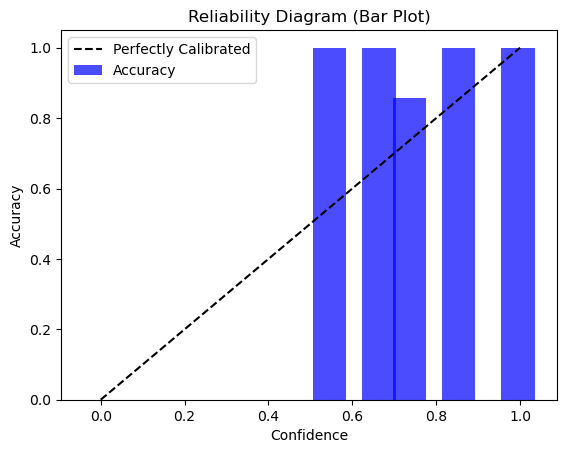

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def reliability_diagram_bars(predictions, labels, bins=10):
    """
    Plot a reliability diagram as a bar chart to assess model calibration.
    predictions: The predicted probabilities.
    labels: The true labels.
    bins: Number of bins to divide the predicted confidence values into.
    """
    # Get predicted confidences (probabilities) and convert to accuracy
    confidences = np.max(predictions, axis=1)  # Get the confidence (max probability)
    accuracy = np.equal(np.argmax(predictions, axis=1), np.argmax(labels, axis=1))  # Compare to true labels

    # Create bins to evaluate calibration
    bin_boundaries = np.linspace(0, 1, bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accuracies, confidences_bin = [], []

    # Evaluate calibration by calculating mean accuracy within each bin
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
        bin_accuracy = np.mean(accuracy[in_bin]) if np.any(in_bin) else 0
        accuracies.append(bin_accuracy)
        confidences_bin.append(np.mean(confidences[in_bin]) if np.any(in_bin) else 0)

    # Plot the reliability diagram using bars for accuracy
    plt.bar(confidences_bin, accuracies, width=0.08, align='center', color='blue', alpha=0.7, label='Accuracy')

    # Plot the reference line for perfect calibration (diagonal)
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')  # Diagonal line for perfect calibration

    # Labels and title
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Reliability Diagram (Bar Plot)')
    plt.legend()
    plt.show()

# Example usage with your predicted probabilities `y_test_pred_proba` and true labels `y_test`
reliability_diagram_bars(y_test_pred_proba, y_test, bins=10)


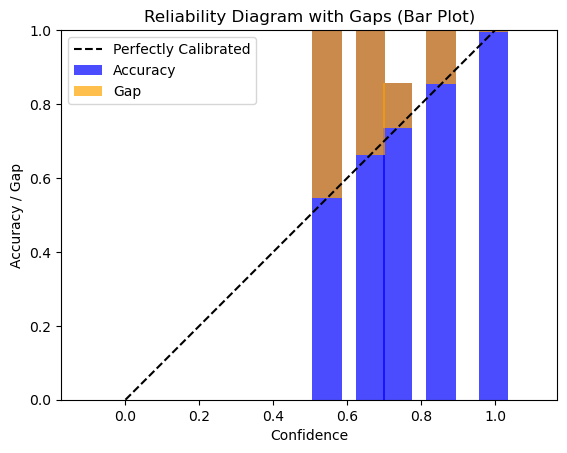

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def reliability_diagram_bars(predictions, labels, bins=10):
    """
    Plot a reliability diagram as a bar chart to assess model calibration.
    predictions: The predicted probabilities.
    labels: The true labels.
    bins: Number of bins to divide the predicted confidence values into.
    """
    # Get predicted confidences (probabilities) and convert to accuracy
    confidences = np.max(predictions, axis=1)  # Get the confidence (max probability)
    accuracy = np.equal(np.argmax(predictions, axis=1), np.argmax(labels, axis=1))  # Compare to true labels

    # Create bins to evaluate calibration
    bin_boundaries = np.linspace(0, 1, bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accuracies, confidences_bin, gaps = [], [], []

    # Evaluate calibration by calculating mean accuracy within each bin
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
        bin_accuracy = np.mean(accuracy[in_bin]) if np.any(in_bin) else 0
        accuracies.append(bin_accuracy)
        confidences_bin.append(np.mean(confidences[in_bin]) if np.any(in_bin) else 0)

        # Calculate the gap (difference between confidence and accuracy)
        gap = np.mean(confidences[in_bin]) - bin_accuracy if np.any(in_bin) else 0
        gaps.append(gap)

        # # Print the values for the gaps, accuracies, and confidences for each bin
        # print(f"Bin: ({bin_lower:.2f}, {bin_upper:.2f})")
        # print(f"  Confidence: {confidences_bin[-1]:.2f}")
        # print(f"  Accuracy: {bin_accuracy:.2f}")
        # print(f"  Gap: {gap:.2f}")
        # print("-" * 30)

    # Plot the reliability diagram using bars for accuracy
    plt.bar(confidences_bin, accuracies, width=0.08, align='center', color='blue', alpha=0.7, label='Accuracy')

    # Plot the gaps between predicted confidence and accuracy stacked above the accuracy bars
    plt.bar(confidences_bin, gaps, width=0.08, align='center', bottom=accuracies, color='orange', alpha=0.7, label='Gap')

    # Plot the reference line for perfect calibration (diagonal)
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')  # Diagonal line for perfect calibration

    # Equal scaling for x and y axis to ensure comparison between the bars
    plt.axis('equal')

    # Labels and title
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy / Gap')
    plt.title('Reliability Diagram with Gaps (Bar Plot)')
    plt.legend()
    plt.show()

# Example usage with your predicted probabilities `y_test_pred_proba` and true labels `y_test`
reliability_diagram_bars(y_test_pred_proba, y_test, bins=10)


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute Expected Calibration Error (ECE)
def expected_calibration_error(predictions, labels, bins=10):
    """
    Compute the Expected Calibration Error (ECE).
    predictions: The predicted probabilities (e.g., output from softmax).
    labels: The true labels (integer-encoded or one-hot encoded).
    bins: Number of bins to divide the predicted confidence values into.
    """
    # Ensure labels are integer-encoded (convert if they are one-hot encoded)
    if len(labels.shape) > 1:  # If labels are one-hot encoded, convert to integer encoding
        labels = np.argmax(labels, axis=1)

    confidences = np.max(predictions, axis=1)  # Get the confidence (max probability)
    accuracy = np.equal(np.argmax(predictions, axis=1), labels)  # Compare to true labels directly

    # Create bins to evaluate calibration
    bin_boundaries = np.linspace(0, 1, bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accuracies, confidences_bin = [], []

    # Evaluate calibration by calculating mean accuracy within each bin
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
        bin_accuracy = np.mean(accuracy[in_bin]) if np.any(in_bin) else 0
        accuracies.append(bin_accuracy)
        confidences_bin.append(np.mean(confidences[in_bin]) if np.any(in_bin) else 0)

    # Compute the ECE value (weighted average of bin-wise accuracy differences)
    ece = np.sum(np.abs(np.array(confidences_bin) - np.array(accuracies)) * (np.array(bin_uppers) - np.array(bin_lowers)))
    return ece

# Function to compute Maximum Calibration Error (MaxCE)
def maximum_calibration_error(predictions, labels, bins=10):
    """
    Compute the Maximum Calibration Error (MaxCE).
    predictions: The predicted probabilities.
    labels: The true labels (integer-encoded or one-hot encoded).
    bins: Number of bins to divide the predicted confidence values into.
    """
    # Ensure labels are integer-encoded (convert if they are one-hot encoded)
    if len(labels.shape) > 1:
        labels = np.argmax(labels, axis=1)

    confidences = np.max(predictions, axis=1)  # Get the confidence (max probability)
    accuracy = np.equal(np.argmax(predictions, axis=1), labels)  # Compare to true labels

    # Create bins to evaluate calibration
    bin_boundaries = np.linspace(0, 1, bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accuracies, confidences_bin = [], []

    # Evaluate calibration by calculating mean accuracy within each bin
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
        bin_accuracy = np.mean(accuracy[in_bin]) if np.any(in_bin) else 0
        accuracies.append(bin_accuracy)
        confidences_bin.append(np.mean(confidences[in_bin]) if np.any(in_bin) else 0)

    # Compute the MaxCE value as the maximum of the absolute differences
    max_ce = np.max(np.abs(np.array(confidences_bin) - np.array(accuracies)))
    return max_ce

# Function to compute class-wise Expected Calibration Error (ECE per class)
def classwise_expected_calibration_error(predictions, labels, num_classes, bins=10):
    """
    Compute class-wise Expected Calibration Error (ECE).
    predictions: The predicted probabilities (e.g., output from softmax).
    labels: The true labels (integer-encoded or one-hot encoded).
    num_classes: The number of classes in the classification task.
    bins: Number of bins to divide the predicted confidence values into.
    """
    class_ece = []

    # Ensure labels are integer-encoded
    if len(labels.shape) > 1:  # If labels are one-hot encoded, convert to integer encoding
        labels = np.argmax(labels, axis=1)

    for class_idx in range(num_classes):
        # Create a binary vector for the current class
        class_labels = (labels == class_idx).astype(int)  # Create a binary vector for current class
        class_predictions = predictions[:, class_idx]  # Predictions for the current class

        # Compute the Expected Calibration Error for the class
        ece_class = expected_calibration_error(np.column_stack([1-class_predictions, class_predictions]), class_labels, bins)
        class_ece.append(ece_class)

    return np.array(class_ece)

# Function to compute Adaptive Expected Calibration Error (Adaptive ECE)
def adaptive_expected_calibration_error(predictions, labels, bins=10):
    """
    Compute the Adaptive Expected Calibration Error (Adaptive ECE).
    predictions: The predicted probabilities (e.g., output from softmax).
    labels: The true labels (integer-encoded).
    bins: Number of bins to divide the predicted confidence values into.
    """
    # Ensure labels are integer-encoded (convert if they are one-hot encoded)
    if len(labels.shape) > 1:
        labels = np.argmax(labels, axis=1)

    confidences = np.max(predictions, axis=1)  # Get the confidence (max probability)
    accuracy = np.equal(np.argmax(predictions, axis=1), labels)  # Compare to true labels

    # Create bins to evaluate calibration
    bin_boundaries = np.linspace(0, 1, bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accuracies, confidences_bin = [], []
    adaptive_ce = []

    # Evaluate calibration by calculating mean accuracy within each bin
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences >= bin_lower) & (confidences < bin_upper)
        bin_accuracy = np.mean(accuracy[in_bin]) if np.any(in_bin) else 0
        accuracies.append(bin_accuracy)
        confidences_bin.append(np.mean(confidences[in_bin]) if np.any(in_bin) else 0)

        # Adaptive calibration error for each bin
        adaptive_bin_ce = np.abs(np.mean(confidences[in_bin]) - bin_accuracy) if np.any(in_bin) else 0
        adaptive_ce.append(adaptive_bin_ce)

    # Adaptive Expected Calibration Error is the average of the adaptive bin errors
    adaptive_ece = np.mean(adaptive_ce)
    return adaptive_ece


# Example usage with your predicted probabilities `y_test_pred_proba` and true labels `y_test`
num_classes = 9  # Set to the number of classes in your dataset (9 in your case)

# Ensure y_test is integer-encoded (if not already)
y_test = np.array(y_test).astype(int)  # Ensure y_test is integer-encoded

# Calculate ECE
ece_value = expected_calibration_error(y_test_pred_proba, y_test, bins=10)
print(f"Expected Calibration Error (ECE): {ece_value:.4f}")

# Calculate MaxCE
max_ce_value = maximum_calibration_error(y_test_pred_proba, y_test, bins=10)
print(f"Maximum Calibration Error (MaxCE): {max_ce_value:.4f}")

# Calculate Class-wise ECE
classwise_ece_values = classwise_expected_calibration_error(y_test_pred_proba, y_test, num_classes, bins=10)
print(f"Class-wise Expected Calibration Error (ECE) values: {classwise_ece_values}")

# Calculate Adaptive ECE
adaptive_ece_value = adaptive_expected_calibration_error(y_test_pred_proba, y_test, bins=10)
print(f"Adaptive Expected Calibration Error (Adaptive ECE): {adaptive_ece_value:.4f}")


Expected Calibration Error (ECE): 0.1063
Maximum Calibration Error (MaxCE): 0.4541
Class-wise Expected Calibration Error (ECE) values: [0.05613089 0.08559735 0.100126   0.09831476 0.08222798 0.04059619
 0.05872783 0.0378763  0.11146771]
Adaptive Expected Calibration Error (Adaptive ECE): 0.1063
